# Tracking High Frequency Cointegration in the US Stock Market
### Filtering Approch

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pykalman as pk
import copy

from tqdm import tqdm
from scipy.stats import norm
from filterpy.monte_carlo import stratified_resample

## Data Preprocessing

In [2]:
# Read the cointegration dataset

meas = pd.read_csv('to_track.csv')

aux = list(meas.Pairings.apply(lambda x: x[1:-1].split(',')))
for i in range(len(aux)):
    aux[i] = [int(elem) for elem in aux[i]]
    
meas.Pairings = aux

couples = list()
i = 0
couples.append(meas.iloc[i].Pairings)

while meas.iloc[i+1].Pairings not in couples:
    i += 1
    couples.append(meas.iloc[i].Pairings)

## Kalman Filter class

CLASS ATTRIBUTES
- $\mu_0$: the mean of hidden state;
- $\Sigma_0$: the variance of the hidden state;
- __model__: the Kalman Filter itself taken from the *pykalman* library;
- __loglikelihood__: the loglikelihood of the observation.

CLASS METHODS
- __init__: initialize the Kalman Filter with the parameters: seed for the reproducibility, $\mu_0$ and $\Sigma_0$;
- __first_step__: does the first step of the Kalman Filter (using the function _filter_) using _obs_ as the observation and updates $\mu_0$ and $\Sigma_0$;
- __update_step__: after the first step updates the model (using the function *filter_update*) using _obs_ as the observation and _err_ as the observation covariance.

COMMENT

For the transition matrix and the observation matrix see the state-space model in the pdf.

In [3]:
class Filter:
    
    def __init__(self, seed, mu_0, sigma_0):
        
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        
        self.model = pk.KalmanFilter(transition_matrices = np.array([1.]),
                       observation_matrices = np.array(1).reshape(-1,1),
                       initial_state_mean = self.mu_0,
                       initial_state_covariance = self.sigma_0,
                       random_state = seed
                       )
        
        self.loglikelihood = -1
        
    def first_step(self, obs):
        
        self.mu_0, self.sigma_0 = self.model.filter(obs)
        self.mu_0 = self.mu_0.flatten()
        self.sigma_0 = self.sigma_0.flatten()
        
    def update_step(self, obs, err):
        
        self.mu_0, self.sigma_0 = self.model.filter_update(filtered_state_mean = self.mu_0,
                                        filtered_state_covariance = self.sigma_0,
                                        observation_covariance = err,
                                        observation = np.array(obs).reshape(-1,1)
                                        )
    
        self.mu_0 = self.mu_0.flatten()    
        self.sigma_0 = self.sigma_0.flatten()        
        self.loglikelihood = norm.pdf(obs, self.mu_0, err + self.sigma_0)

## Particle Class

CLASS ATTRIBUTES
- __W__: an array of N elements (where N is the maximum number of targets) where the i-th element is the weight of the Particle for the i-th target;
- __M__: an array of N elements where the i-th element is the mean of the i-th target;
- __C__: an array of N elements where the i-th element is the covariance of the i-th target;
- $M_0$: an array of N elements where the i-th element is the prior mean of the i-th target;
- $C_0$: an array of N elements where the i-th element is the prior covariance of the i-th target;
- __seed__: a number to set the seed of the Kalman Filter for reproducibility purposes;
- __filter__: a list of N Kalman Filter, one for each target, initialized with $M_0$ and $C_0$;
- __life__: an array of N elements where the i-th element represents the state of the particle with respect to the i-th target: 0 for dead and 1 for alive;
- __clutter_count__: an array of N elements where the i-th element represents the number of consecutive observation of the i-th target which are labeled as clutter.

CLASS METHODS
- __init__: initialize the Particle given $M_0$, $C_0$, W, N and the seed;
- __death__: kills the particle at the corrisponding index resetting all its parameters and the filter;
- __birth__: birth of a new particle at the corrisponding index, first_step of the filter giving as observation the gaussian noise (with standard deviation as input and zero mean) corrupted observation and updates the target M and C;
- __update__: updates the particle at the corrisponding index using the *update_step* method of its filter with input the observation and its covariance, updates the target M and C, updates the weight with the loglikelihood of the observation and if the observation was clutter increases by 1 the clutter_count.

In [4]:
class Particle:
    def __init__(self, M_0, C_0, W, N, seed):
        self.W = np.array([W for i in range(N)])
        self.M = np.zeros(N)
        self.C = np.zeros(N)        
        self.M_0 = M_0
        self.C_0 = C_0
        self.seed = seed
        self.filter = [Filter(seed, np.array(self.M_0[i]), np.array(self.C_0[i])) for i in range(N)]
        self.life = np.zeros(N)
        self.clutter_count = np.zeros(N)
        
    def death(self, index):
        self.life[index] = 0
        self.M[index] = 0
        self.C[index] = 0
        self.filter[index] = Filter(self.seed, np.array(self.M_0[index]), np.array(self.C_0[index]))
        self.clutter_count[index] = 0
        self.W[index] = 1./N
        
    def birth(self, index, obs, std_particles):
        self.life[index] = 1
        self.filter[index].first_step(obs + np.random.normal(0,std_particles,1))
        self.M[index], self.C[index] = self.filter[index].mu_0[0], self.filter[index].sigma_0[0]
        
    def update(self, index, obs, Q, clutter = 0):
        self.filter[index].update_step(obs, Q)
        self.M[index], self.C[index] = self.filter[index].mu_0[0], self.filter[index].sigma_0[0]
        self.W[index] = self.filter[index].loglikelihood
        if clutter:
            self.clutter_count[index] += 1

## Parameters

- __p_death__: the probability of death of a target;
- __p_birth__: the probability of birth of a target;
- __particles__: a list of Particle;
- __std_particles__: the standard deviation of the first observation at the birth of a new target;
- __NP__: the number of Particle in __particles__;
- __N__: the maximum number of targets;
- $M_0$: an array of N elements representing the prior mean of every target;
- $C_0$: an array of N elements representing the prior covariance of every target;
- __Majority__: the minimum number of Particle that identify an observation as clutter in order to say that the observation is actually clutter;
- __NC__: number of consecutive clutter observations before the death of the target;
- __Q__: the covariance of the measurement when updating;
- __T__: the final time;
- __result__: a list of lists where each list is the __particles__ at a certain timestep.

In [5]:
p_death = 0.95
p_birth = 0.95

particles = list()
std_particles = 2.
NP = 10
N = len(couples)
M_0 = np.zeros(N)
C_0 = np.ones(N)*(15**2)
Majority = NP/2
NC = 3
Q = np.array([1])

T = (max(meas.t.unique()) + 1)
result = list()

## Rao-Blackwellized Particle Filter with Stratified Resampling

*is_clutter*

INPUT
- __obs__: the current observation;
- __P__: the list of Particle;
- __index__: the index of the target.

OUTPUT
- __0__ if it isn't clutter;
- __1__ if it is clutter.

WORKING

Checks how many Particle we have for which the observation is further away, from the mean of the target, than two standard deviation of the target. If the number of Particle is greater or equal than the *Majority* parameter the observation is said to be clutter, otherwise it isn't.

In [6]:
def is_clutter(obs, P, index):
    count = 0
    for i in range(NP):
        if abs(obs - P[i].M[index]) >= 2 * np.sqrt(P[i].C[index]):
            count += 1
        if count >= Majority:
            return 1
    return 0

*predict*

INPUT
- __P__: the list of Particle;
- __obs__: the array of all the observation for every target at a certain timestep.

WORKING

See *Pseudo_Algorithm.pdf* for the specifics.

In [7]:
def predict(P, obs):
    check = False
    for j in range(N):
        
        if obs[j] == 0:
            if P[0].life[j]:
                if np.random.rand(1) < p_death:
                    for z in range(NP):
                        P[z].death(j)
        
        else:
            if P[0].life[j] == 0:
                if np.random.rand(1) < p_birth:
                    for z in range(NP):
                        P[z].birth(j, obs[j], std_particles)
            else:
                if is_clutter(obs[j], P, j):
                    for z in range(NP):
                        P[z].update(j, P[z].M[j], Q, 1)
                        if P[z].clutter_count[j] == NC:
                            check = True
                else:                    
                    for z in range(NP):
                        P[z].clutter_count[j] = 0
                        P[z].update(j, obs[j], Q)
                   
                if check:
                    for z in range(NP):
                        P[z].death(j)
                    check = False

*normalize_weights*

INPUT
- __P__: the list of Particle.

WORKING

Cycles through all the targets and for each of them normalizes the weights of the Particle:

$$W_i[index]=\frac{W_i[index]}{\sum\limits_{j=1}^{NP}W_j[index]}\;\;\;\;\;\forall i=1,...,NC$$

In [8]:
def normalize_weights(P):
    for i in range(N):
        aux = sum([P[j].W[i] for j in range(NP)])
        for j in range(NP):
            P[j].W[i] = P[j].W[i]/aux

*eff_particles*

INPUT
- __P__: list of Particle after the weight normalization;
- __index__: the index of the target.

OUTPUT

The number of effective Particle for target in *index* position.

WORKING

Calculates the number of effective Particle for target in *index* position as:

$$N_{eff}=\frac{1}{\sum\limits_{i=1}^{NP}W_i^2[index]}$$

In [9]:
def eff_particles(P, index):
    aux_sum = 0
    for i in range(NP):
        aux_sum += P[i].W[index]**2
    return 1. / aux_sum

*resample*

INPUT
- __P__: the list of Particle;
- __t__: the timestep (just for print reasons).

WORKING

Cycles through all the targets and if the number of effective Particle is less or equal than half the number of Particle, for a specific target, it resamples using the *stratified_resample* from the *filterpy* library.

In [10]:
def resample(P,t):
    for i in range(N):
        if eff_particles(P, i) <= NP/2.:
            print('Resample done at time ',t,' for index ', i)
            index = stratified_resample(np.array([P[j].W[i] for j in range(NP)]))
            aux_mean = np.array([P[j].M[index[j]] for j in range(NP)])
            aux_cov = np.array([P[j].C[index[j]] for j in range(NP)])
            for j in range(NP):
                P[j].W[i] = 1./N
                P[j].M[i] = aux_mean[j]
                P[j].C[i] = aux_cov[j]

## Main

Creation of the *result* cycling through all the timesteps.

In [11]:
for i in range(NP):
    particles.append(Particle(M_0, C_0, 1./NP, len(couples), i))

for i in tqdm(range(T)):
    predict(particles, np.array(meas[meas['t'] == i]['Weights']))
    normalize_weights(particles)
    resample(particles, i)
    result.append(copy.deepcopy(particles))

100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [02:53<00:00,  2.03it/s]


Creation of the prediction for every target at every timestep as:

$$T_i(t)=\sum\limits_{j=1}^{NC}M_j[index](t)*W_j[index](t)$$

In [12]:
predicted = list()
for t in tqdm(range(T)):
    res = list()
    for i in range(N):
        aux = 0
        for j in range(NP):
            aux += result[t][j].M[i] * result[t][j].W[i]
        res.append(aux)
    predicted.append(np.array(res))

100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:01<00:00, 316.64it/s]


## Plot of the results

*plot*

INPUT
- __elem__: np.array of int containig the indexes of the targets to plot;
- __data__: the list of all the predicted targets for every timestep;
- __split__: the number of targets to plot per figure (default is 10);
- __y__: the y_lim of the plot (default is None).

In [28]:
def plot(elem, data, split = 10, y = None):
    n_elem = len(elem)
    
    for j in range(int(np.ceil(n_elem/split))):
        plt.figure(j+1)
        for i in range(split * j, min(split * (j+1), n_elem)):
            list_index = elem[i] + np.arange(T)*N
            aux_1 = np.array(meas.iloc[list_index]['Weights']).flatten()
            aux_1[aux_1 == 0] = np.nan

            aux_2 = list()
            for t in range(T):
                aux_2.append(data[t][elem[i]])
            aux_2 = np.array(aux_2)
            aux_2[aux_2 == 0] = np.nan

            plt.plot(aux_1, 'ro', markersize = 1)
            plt.plot(aux_2, 'bx', markersize = 0.7)
            plt.xlim([0, 350])
            if y:
                plt.ylim(y)
            plt.xlabel('t')
            plt.ylabel('Weights')
            plt.title('Comparison between predicted and observed')
            plt.legend(['Observed','Predicted'])

            plt.show()

Finding the targets that have a number of observations that is more than a certain threshold to plot them.

In [29]:
threshold = 150
index_list = list()
for i in tqdm(range(N)):
    list_index = i + np.arange(T)*N
    aux = np.array(meas.iloc[list_index]['Weights']).flatten()
    if sum(sum([aux != 0])) >= threshold:
        index_list.append(i)
index_list = np.array(index_list)
print('Number of elements: ',len(index_list))

100%|██████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 3093.07it/s]

Number of elements:  34


<IPython.core.display.Javascript object>


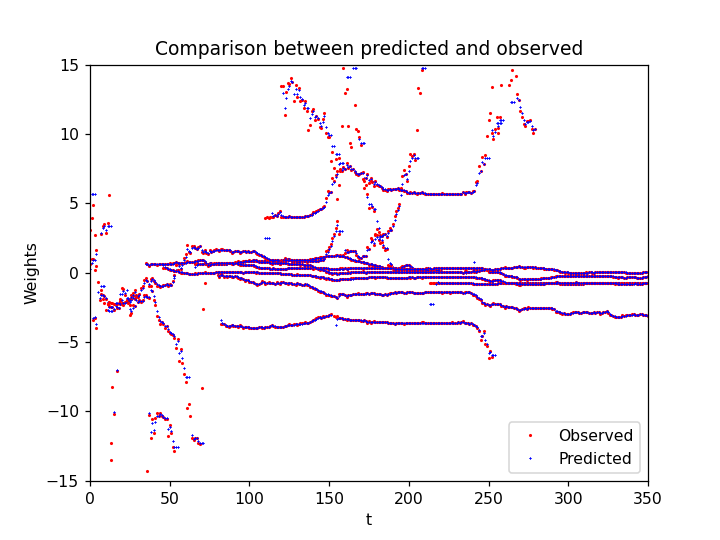

<IPython.core.display.Javascript object>


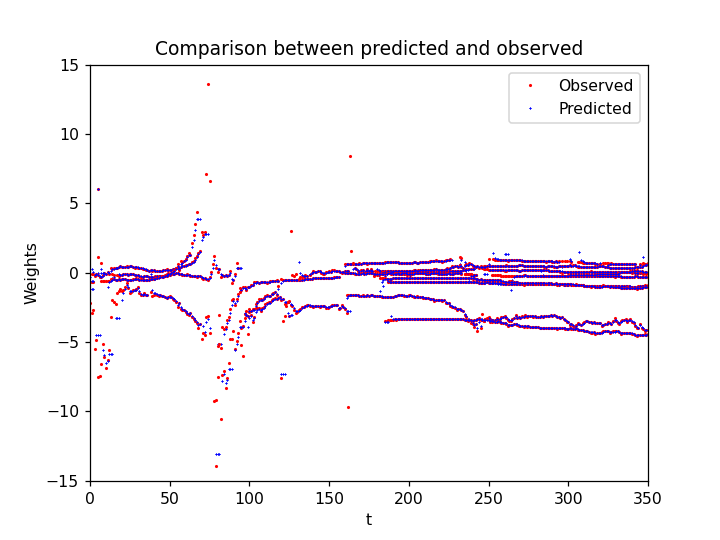

<IPython.core.display.Javascript object>


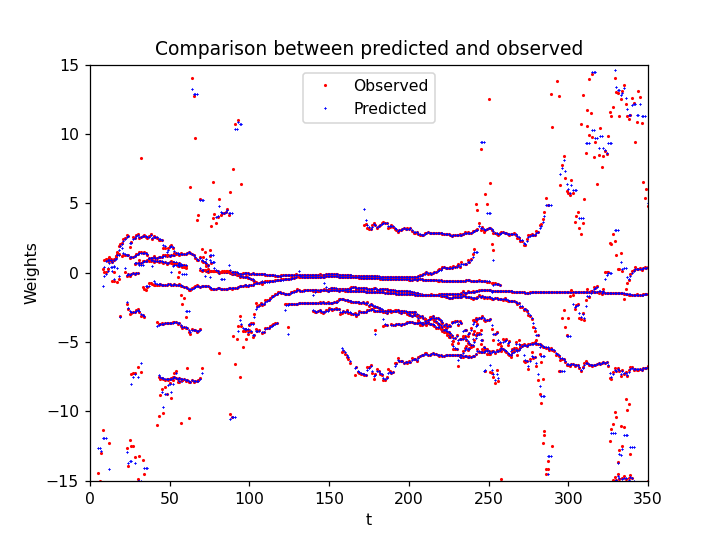

<IPython.core.display.Javascript object>


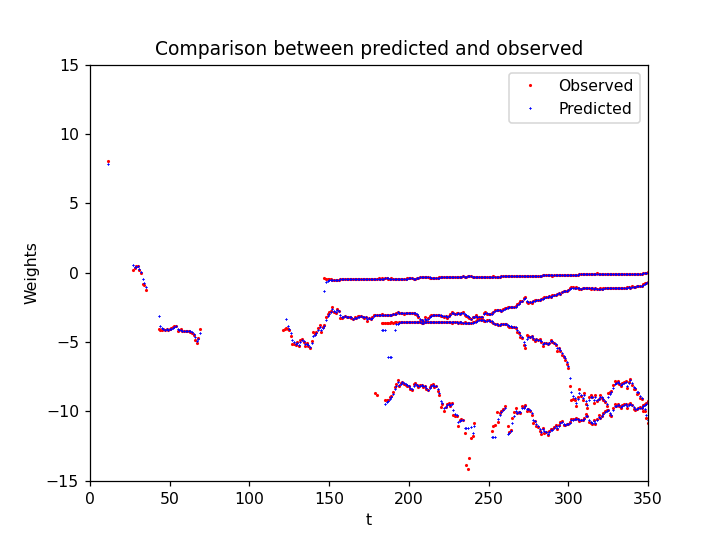

In [79]:
%matplotlib notebook

plot(index_list, predicted, y=[-15,15])

<IPython.core.display.Javascript object>


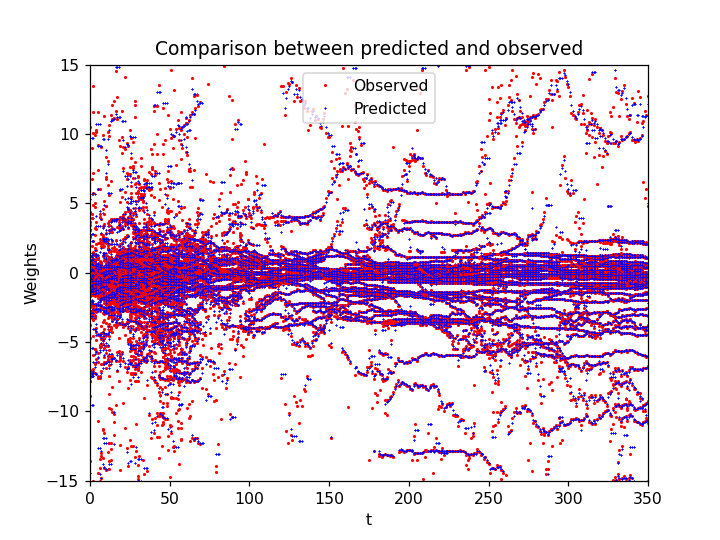

In [77]:
%matplotlib notebook

plot(np.arange(N), predicted, split=N, y=[-15,15])